In [28]:
import xarray as xr
import numpy as np
import zarr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import matplotlib.colors as colors
import cmasher
import pandas as pd
import cmocean
from scipy import stats

from scipy.ndimage import median_filter, uniform_filter

%matplotlib ipympl

In [29]:
from LGR_altered.lgr import *
from LGR_altered.jacobian import *
from LGR_altered.classes import *
from LGR_altered.plotting import *

# Load Data - dsCDF and ds NEED TO MATCH

In [63]:
ds = xr.open_zarr('/Users/jordan/Documents/CICOES/data/posterData/1200p_15c_dt15.zarr')
#ds = xr.open_zarr('/Users/jordan/Documents/CICOES/data/largeGrid00/dense.zarr')
sps = 30                 # seconds per step, the number of seconds between each observation

dsCDF = xr.load_dataset('/Users/jordan/Documents/CICOES/data/cape_large_00.nc', decode_times = False)

In [31]:
# code block to keep only first X - 1 time steps
# ds = ds.isel(obs = slice(0,4))

In [32]:
dsCDF

<xarray.Dataset> Size: 128MB
Dimensions:              (tracer: 1, s_rho: 5, s_w: 6, eta_rho: 130,
                          xi_rho: 450, xi_u: 449, eta_v: 129)
Coordinates: (12/13)
  * s_rho                (s_rho) float64 40B -0.9 -0.7 -0.5 -0.3 -0.1
  * s_w                  (s_w) float64 48B -1.0 -0.8 -0.6 -0.4 -0.2 0.0
    x_rho                (eta_rho, xi_rho) float64 468kB -1.05e+03 ... 1.05e+03
    y_rho                (eta_rho, xi_rho) float64 468kB 0.0 0.0 ... 1.2e+03
    x_u                  (eta_rho, xi_u) float64 467kB -1.048e+03 ... 1.048e+03
    y_u                  (eta_rho, xi_u) float64 467kB 0.0 0.0 ... 1.2e+03
    ...                   ...
    y_v                  (eta_v, xi_rho) float64 464kB 3.037 3.037 ... 1.192e+03
    x_psi                (eta_v, xi_u) float64 463kB -1.048e+03 ... 1.048e+03
    y_psi                (eta_v, xi_u) float64 463kB 3.037 3.037 ... 1.192e+03
    ocean_time           float64 8B 2.22e+04
    z_rho                (eta_rho, xi_rho, s_rho) float64 2MB 10.31 ... -0.4613
    z_w                  (eta_rho, xi_rho, s_w) float64 3MB 10.0 ... 0.02012
Dimensions without coordinates: tracer, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/209)
    ntimes               int32 4B 86400
    ndtfast              int32 4B 20
    dt                   float64 8B 1.0
    dtfast               float64 8B 0.05
    dstart               float64 8B 0.0
    nHIS                 int32 4B 600
    ...                   ...
    qv                   (eta_v, xi_rho) float64 464kB nan nan ... -0.1203
    vorticity            (eta_v, xi_u) float64 463kB nan nan ... 0.00109
    theta_wave           (eta_rho, xi_rho) float32 234kB nan nan nan ... 0.0 0.0
    u_wave               (eta_rho, xi_rho) float32 234kB nan nan ... -0.0 -0.0
    v_wave               (eta_rho, xi_rho) float32 234kB nan nan ... -1.0 -1.0
    helicity             (eta_v, xi_u) float64 463kB 0.0 0.0 ... -0.108 -0.1173
Attributes: (12/28)
    file:              /Users/wit/COAWST/Projects/cape/results/ocean_his_0000...
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             cape
    var_info:          ROMS/External/varinfo.dat
    ...                ...
    compiler_command:  /Users/wit/mambaforge/envs/coawst/bin/mpif90
    compiler_flags:    -frepack-arrays -fallow-argument-mismatch -O3 -O3 -I/u...
    tiling:            002x004
    history:           ROMS/TOMS, Version 3.9, Monday - July 29, 2024 - 12:43...
    ana_file:          ROMS/Functionals/ana_btflux.h, /Users/wit/COAWST/Proje...
    CPP_options:       cape, ANA_BSFLUX, ANA_BTFLUX, ANA_FSOBC, ANA_INITIAL, ...

# Computation - Harms

## Parameters

In [33]:
# Set computational parameters for LGR - original values
t = 15                         # time duration for LCS analysis - 15
kNN = 5         # Number of nearest neighbors to find for each particle - 10 (use 25 for 1024, 15 for 100, 17 for even)
reg_type = 'radialGaussian'     # 'None' or 'radialGaussian' - 'radialGaussian'
sigma = 0.1                    # standard deviation if reg_type is radial_gaussian - 0.1
lam = 0.000000001            # Regularizer for the regression - 0.000000001
nx_int = 150                    # grid length in x for interpolation (plotting) - 150

# new interpolation constants
smooth = 0.001               # how much to smooth things over during interpolation - 0 initially, 0.001 optimal

# Specify which metrics to compute from ["ftle", "lavd", "dra", "vort"]
metrics = ["ftle", "lavd", "dra", "vort"]

# Set parameters for particleList
# sps = 300                 # seconds per step, the number of seconds between each observation - defined above for now
tvec = np.arange(0, ds.sizes['obs']*sps, sps)

## Record Particle Trajectories

In [34]:
particleList = []

for i in range(ds.sizes["trajectory"]) :

    # provide loading bar
    if i % 100 == 0 :
        print("particle: {}".format(i))
    
    tvec = np.arange(0, ds.sizes['obs']*sps, sps)
    x,y = ds.isel(trajectory = i).lon.values, ds.isel(trajectory = i).lat.values

    idNaN = np.isnan(x)
    x = x[~idNaN]
    y = y[~idNaN]
    tvec = tvec[~idNaN]
    
    if any(np.isnan(x)) :
        print("na found")
        print(x)
        print(y)
        assert False

    # scale by 30s
    #t = np.arange(0, ds.sizes['obs'])
    #tvec = np.arange(0, ds.sizes['obs']*sps, sps)
    # takes the positions xxxxx,yyyyy and takes the transpose: xy, xy, as desired
    P = SimpleParticle( np.array([x,y]).T, tvec, i)
    particleList.append(P)

# particleList[0].pos[1000] # This is the thousandth element of the first particle's position list, a lon and lat pair.

particle: 0
particle: 100
particle: 200
particle: 300
particle: 400
particle: 500
particle: 600
particle: 700
particle: 800
particle: 900
particle: 1000
particle: 1100


## Compute Particle Metrics

In [35]:
# Generate the regression function
regfun = setRegressionFunction(kernel=reg_type, lam=lam, sig=sigma)

In [36]:
# Generate a data frame
df = generateDF(particleList, kNN)
n_particles = len(df['indices'][0])

KNN: t = 0.0
KNN: t = 750.0
KNN: t = 1500.0
KNN: t = 2250.0
KNN: t = 3000.0


In [37]:
# Perform the regressions
import warnings
warnings.filterwarnings("ignore")
calcJacobianAndVelGrad(df, regfun=regfun)

Regression: t = 0.0
Regression: t = 750.0
Regression: t = 1500.0
Regression: t = 2250.0
Regression: t = 3000.0


In [38]:
# Compute the metrics on each particle trajectory
computeMetrics(df, t, metric_list=metrics)

Metrics: t = 0.0
Metrics: t = 750.0
Metrics: t = 1500.0
Metrics: t = 2250.0
Metrics: t = 3000.0


In [39]:
# drop the last row as it is prone to errors
df = df[:-1]

## Interpolate to a Grid

In [40]:
# Interpolate onto a grid of even squares in each direction
#xvec = np.linspace(-300, 300, nx_int)
#yvec = np.linspace(0, 150, int(nx_int/4))

# this generates the meshgrid from the x and y values of the model grid
# we make the grid sparcer for efficiency
cff = 1    # every _ value is removed so efficiency is _^2 - set to 1 for error!
xvec = dsCDF.x_psi[0,:].values #[::cff]
yvec = dsCDF.y_psi[:,0].values #[::cff]

gridvectors = [xvec, yvec]

if n_particles < 2000:  # 1000
    generateFields(df, gridvectors, approach='rbf', method='multiquadric', smooth = smooth)
    interpstr = 'rbf_mq'
else:
    generateFields(df, gridvectors, approach='interp', method='cubic')
    interpstr = 'int3'

Interpolation: t = 0.0
Interpolation: t = 750.0
Interpolation: t = 1500.0
Interpolation: t = 2250.0
Interpolation: t = 3000.0


# Error Computation

## Extracting vort (LGR vorticity) and romvort (ROMS vorticity) - Harms

In [41]:
# which timestep to consider
tstep = 0

### our computed quantities
# .loc selects a timestep, and the scalarfields column. Each element is a dictionary, so we pull out the one we want
# Each dictionary contains a 2d array array, horizontal values in rows, vertical values in columns, used for plotting
# ftle = np.squeeze(df.loc[tstep, 'ScalarFields']['ftle'])
vort = np.squeeze(df.loc[tstep, 'ScalarFields']['vort'])
vort_nofilter = np.copy(vort)
vort.shape

(129, 449)

In [42]:
np.count_nonzero(np.isnan(vort)) 

0

In [43]:
### the projected ROMS vorticity
#romvort = dsCDF['vorticity'].values
romvort = dsCDF['ω_bar'].values

# trim romvort to the same size as vort, both axes at once get every _____th value removed
romvort = romvort[:, ::cff]

In [44]:
# filter vort to not include computed values in areas deeper than 5m.
vort[ dsCDF['h_psi'][:,::cff] >= 10 ] = np.nan
#vort[ dsCDF['y_psi'] > np.nanmax(dsCDF['y_psi']) ] = np.nan
vort.shape

(129, 449)

In [105]:
# unfiltered romvort error
# errorMesh = (vort - romvort)**2
# meanl2normMesh = round( np.sqrt(np.nansum(errorMesh)/ np.count_nonzero(~np.isnan(errorMesh))), 5) 
# meanl2normMesh

## Smoothing romvort With a Local Mean

In [45]:
# where romvort is nan, plug in 0, otherwise keep the original value
romvort_nonan = np.where( np.isnan(romvort), 0, romvort)

romvort_nans = np.where(np.isnan(romvort), np.nan, 0)

romvortmean = uniform_filter(romvort_nonan, size = 5, mode = 'nearest')

romvortmean_nans = romvortmean + romvort_nans

In [46]:
errorMesh = (vort - romvortmean_nans)**2
meanl2norm = round( np.sqrt(np.nansum(errorMesh)/ np.count_nonzero(~np.isnan(errorMesh))), 5) 
meanl2norm

np.float64(0.00596)

#### Correlation

In [47]:
romvortvecmean = romvortmean_nans.flatten()
vortvecmean = vort.flatten()

maskmean = ~np.isnan(romvortvecmean) & ~np.isnan(vortvecmean)
#& ( (vortvec > 0.00001) | (vortvec < -0.00001) )
#& ( (romvortvec > 0.1) | (romvortvec < -0.1) )

corrmean = round(stats.linregress(romvortvecmean[maskmean], vortvecmean[maskmean]).rvalue, 3)
corrmean

np.float64(0.931)

#### Scatterplot

Text(0.5, 1.0, 'vort vs. romvort scatterplot')

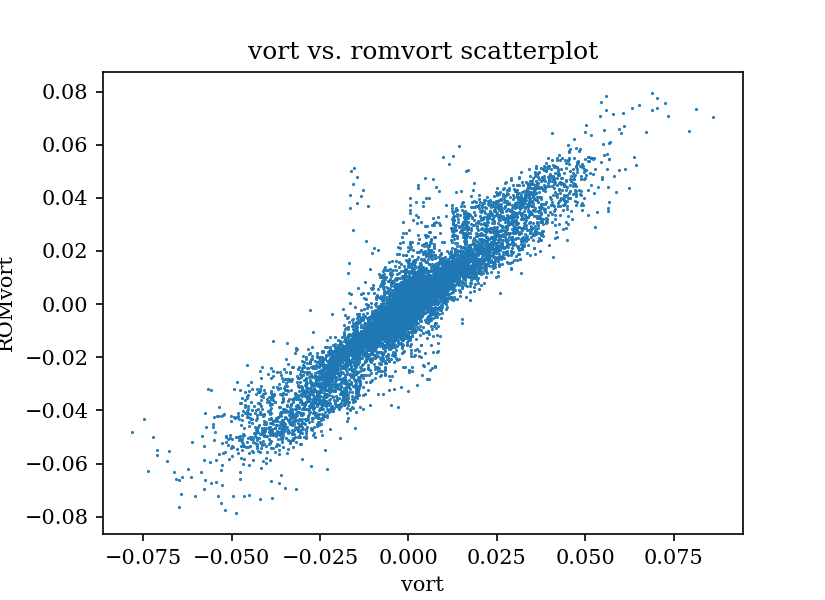

In [48]:
# a scatterplot of the two masked vectors

fig, ax = plt.subplots(figsize = (5.5,4), dpi = 150 )
ax.scatter(vortvecmean[maskmean], romvortvecmean[maskmean], s=0.25)
ax.set_ylabel('ROMvort')
ax.set_xlabel('vort')
ax.set_title('vort vs. romvort scatterplot')

# Plotting

In [49]:
# plotting coordinates
# psi
X, Y = np.meshgrid(xvec, yvec)

# rho
x_rho = dsCDF.x_rho[0,:].values 
y_rho = dsCDF.y_rho[:,0].values
Xrho, Yrho = np.meshgrid(x_rho, y_rho)

plt.close('all')

## Static Plots

### LGR Vorticity Plot at tstep With Particles

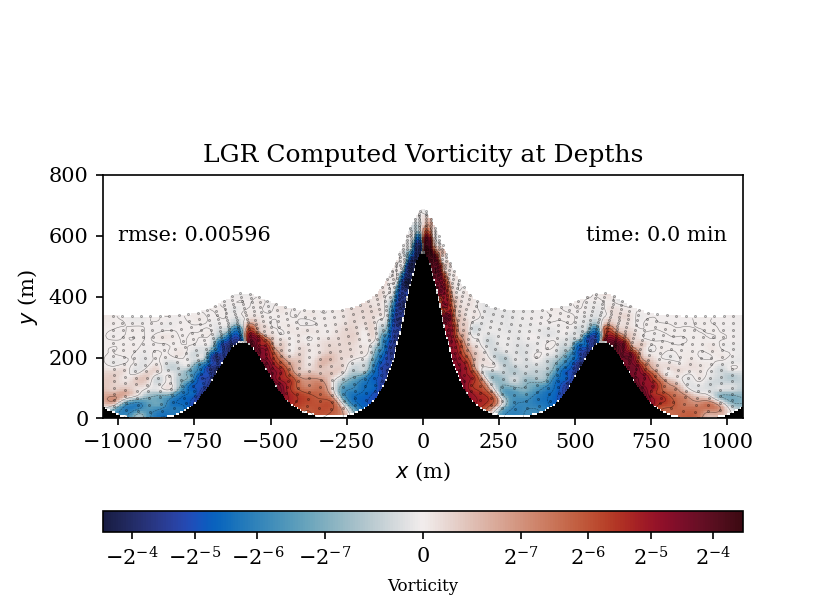

In [24]:
# plt.rcParams.update({"text.usetex": False})

# dpi scales figure up, keeping the base size the same
fig, ax = plt.subplots(figsize = (5.5,4), dpi = 150) 

# vmin and vmax set lower and upper bounds of colormap - derive so centered at 0 based on max value of first array
# vmin, vmax = -max(abs(df['vorticity'].values[0])), max(abs(df['vorticity'].values[0]))
vmin, vmax = -np.nanmax(vort), np.nanmax(vort)
#vmin, vmax = -2e-1, 2e-1

norm = colors.SymLogNorm(linthresh = 0.01, base = 2, vmin = vmin, vmax = vmax)


# symlognorm is linear near 0
vplt = ax.pcolormesh(X, Y, vort, cmap = cmocean.cm.balance, norm = norm) 

# alpha is transparency, k is black
levels = np.linspace(vmin, vmax, 25)
ax.contour(X, Y, vort, levels = levels, linewidths = 0.25, alpha = 0.5, colors = "k")  

#ax.contour(X, Y, vort, norm = norm, linewidths = 0.25, alpha = 0.5, colors = "k")  

# draws the land
ax.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), cmap = 'gray')

# adds a scatterplot of the positions of particles at the timestep we are plotting
ax.scatter(df.loc[tstep].positions[:,0], df.loc[tstep].positions[:,1], s = 0.1, color = "k", alpha = 0.5)  # s = 0.25

# t
ax.text(1000,600,'time: {} min'.format(tstep*sps/60),
        horizontalalignment='right',
        verticalalignment='center')

# kNN
# ax.text(-1000,1100, 'kNN: {}'.format(kNN),
#         horizontalalignment='left',
#         verticalalignment='center')

# L2 normed
ax.text(-1000,600, 'rmse: {}'.format(meanl2norm),
        horizontalalignment='left',
        verticalalignment='center')

# particle counter
# ax.text(0,1100, '{} particles'.format(np.count_nonzero(~np.isnan(df['vorticity'].values[tstep]))),
#         horizontalalignment='center',
#         verticalalignment='center')


# axis atributes
ax.set_title('LGR Computed Vorticity at Depths')
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$y$ (m)')

ax.set_ylim(0,800)
ax.set_xlim(-1050,1050)
ax.set_aspect("equal")

# colorbar - pad is distance below to place it
cbar = fig.colorbar(vplt, orientation = "horizontal", fraction = 0.05, aspect = 30, pad = .20)
cbar.set_label(label='Vorticity', size=8) # can add weight = 'bold'
plt.show()

In [25]:
fig.get_size_inches()

array([5.5, 4. ])

### Unfiltered ROMS Vorticity Plot at tstep With Particles

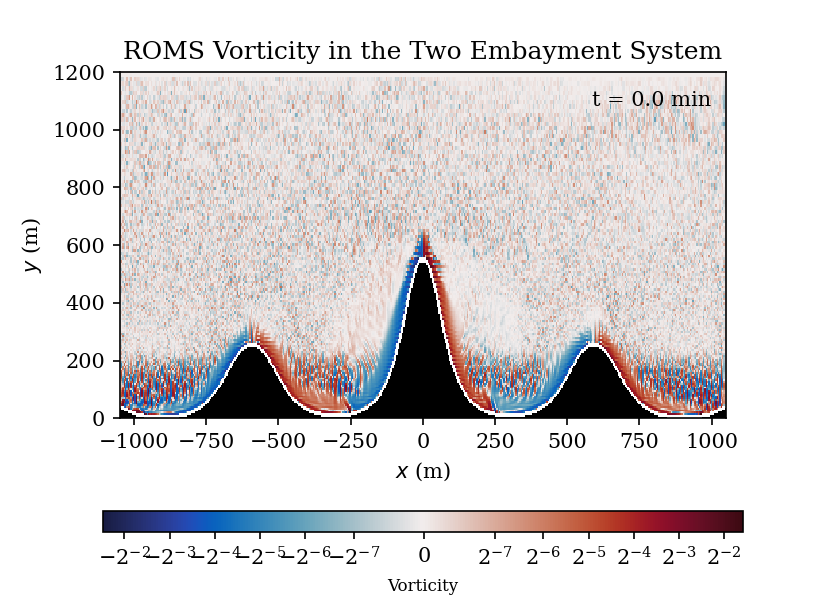

In [26]:
# dpi scales figure up, keeping the base size the same
fig, ax = plt.subplots(figsize = (5.5,4), dpi = 150 )

#vmin, vmax = -np.nanmax(romvort)/3, np.nanmax(romvort)/3
romvplt = ax.pcolormesh(X, Y, romvort, cmap = cmocean.cm.balance, 
                        norm=colors.SymLogNorm(linthresh=0.01, base=2)) # can add vmin and vmax in here

# draws the land
ax.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), cmap = 'gray')

# axis atributes
ax.set_title('ROMS Vorticity in the Two Embayment System')
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$y$ (m)')

ax.set_ylim(0,1200)
ax.set_xlim(-1050,1050)
ax.set_aspect("equal")

# t
ax.text(1000,1100,'t = {} min'.format(tstep*sps/60),
        horizontalalignment='right',
        verticalalignment='center')

# colorbar - pad is distance below to place it
cbar = fig.colorbar(romvplt, orientation = "horizontal", fraction = 0.05, aspect = 30, pad = .20)
cbar.set_label(label='Vorticity', size=8) # can add weight = 'bold'
plt.show()

### Filtered ROMS Vorticity Plot at tstep With Particles

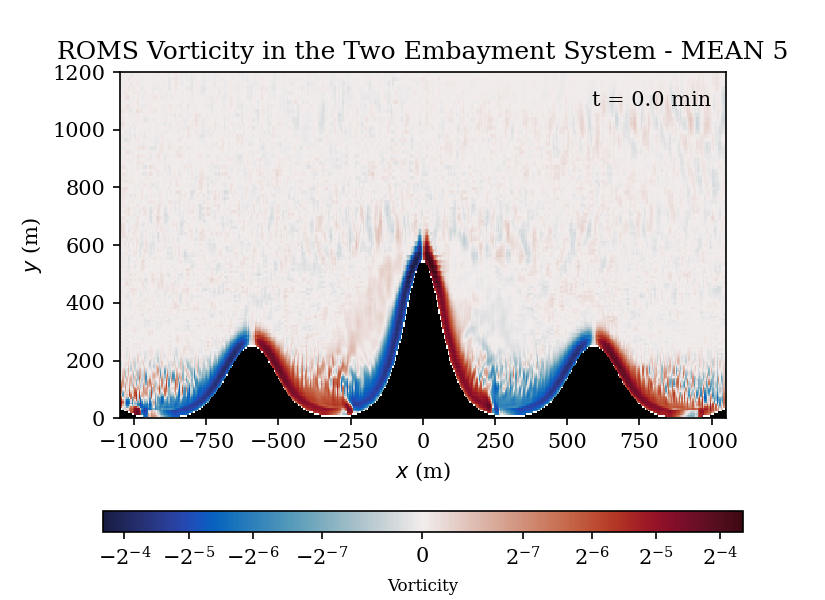

In [178]:
# dpi scales figure up, keeping the base size the same
fig, ax = plt.subplots(figsize = (5.5,4), dpi = 150 )

#vmin, vmax = -np.nanmax(romvort)/3, np.nanmax(romvort)/3
romvmeanplt = ax.pcolormesh(X, Y, romvortmean, cmap = cmocean.cm.balance, 
                        norm=colors.SymLogNorm(linthresh=0.01, base=2)) # can add vmin and vmax in here

# draws the land
ax.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), cmap = 'gray')

# axis atributes
ax.set_title('ROMS Vorticity in the Two Embayment System - MEAN 5')
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$y$ (m)')

ax.set_ylim(0,1200)
ax.set_xlim(-1050,1050)
ax.set_aspect("equal")

# t
ax.text(1000,1100,'t = {} min'.format(tstep*sps/60),
        horizontalalignment='right',
        verticalalignment='center')

# colorbar - pad is distance below to place it
cbar = fig.colorbar(romvmeanplt, orientation = "horizontal", fraction = 0.05, aspect = 30, pad = .20)
cbar.set_label(label='Vorticity', size=8) # can add weight = 'bold'
plt.show()

### POSTER - ROMS and LGR Comparison Plot

In [61]:
# plt.rcParams.update({"text.usetex": False})


# MASK REMOVE, ADD DASHED LINE


plt.close('all')

# dpi scales figure up, keeping the base size the same
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, constrained_layout = True, figsize = (14,14), dpi = 1200) 


romvmeanplt = ax1.pcolormesh(X, Y, romvortmean, cmap = cmocean.cm.balance, 
                        norm=colors.SymLogNorm(linthresh=0.01, base=2)) # can add vmin and vmax in here

# draws the land
ax1.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), 
               cmap = colors.ListedColormap(['#FAF6EB', '#ffffff00']))

# boundary contour
ax1.contour(Xrho, Yrho, dsCDF['h'], levels = [10], colors = 'black', linestyles = 'dashed')

# axis  1 atributes
ax1.set_title('ROMS Vorticity', size = 32)
#ax1.set_xlabel(r'$x$ (m)')
ax1.set_ylabel(r'$y$ (m)', size = 24)

ax1.yaxis.set_tick_params(labelsize=24)

ax1.set_ylim(0,800)
ax1.set_xlim(-1050,1050)
ax1.set_aspect("equal")


# colorbar - pad is distance below to place it
#cbar = fig.colorbar(romvmeanplt, orientation = "horizontal", fraction = 0.05, aspect = 30, pad = .20)
#cbar.set_label(label='Vorticity', size=8) # can add weight = 'bold'








# vmin and vmax set lower and upper bounds of colormap - derive so centered at 0 based on max value of first array
# vmin, vmax = -max(abs(df['vorticity'].values[0])), max(abs(df['vorticity'].values[0]))
vmin, vmax = -np.nanmax(vort), np.nanmax(vort)
#vmin, vmax = -2e-1, 2e-1

norm = colors.SymLogNorm(linthresh = 0.01, base = 2, vmin = vmin, vmax = vmax)


# symlognorm is linear near 0
vplt = ax2.pcolormesh(X, Y, vort_nofilter, cmap = cmocean.cm.balance, norm = norm)  

#ax.contour(X, Y, vort, norm = norm, linewidths = 0.25, alpha = 0.5, colors = "k")  

# draws the land
ax2.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), 
               cmap = colors.ListedColormap(['#FAF6EB', '#ffffff00']), zorder = 10)

# alpha is transparency, k is black
levels = np.linspace(vmin, vmax, 25)
ax2.contour(X, Y, vort_nofilter, levels = levels, linewidths = 0.25, alpha = 0.75, colors = "k") 

# boundary contour
ax2.contour(Xrho, Yrho, dsCDF['h'], levels = [10], colors = 'black', linestyles = 'dashed')

# adds a scatterplot of the positions of particles at the timestep we are plotting
# ax2.scatter(df.loc[tstep].positions[:,0], df.loc[tstep].positions[:,1], s = 0.5, color = "k", alpha = 0.5)  # s = 0.25

# t
ax2.text(1000,600,'time: {} min'.format(tstep*sps/60), size = 24, horizontalalignment='right', verticalalignment='center')

# kNN
# ax.text(-1000,1100, 'kNN: {}'.format(kNN),
#         horizontalalignment='left',
#         verticalalignment='center')

# L2 normed
ax2.text(-1000,600, 'rmse: {}'.format(meanl2norm), size = 24, horizontalalignment='left', verticalalignment='center')

# particle counter
# ax.text(0,1100, '{} particles'.format(np.count_nonzero(~np.isnan(df['vorticity'].values[tstep]))),
#         horizontalalignment='center',
#         verticalalignment='center')


# axis 2 atributes
ax2.set_title('LGR Vorticity', size = 32)
ax2.set_xlabel(r'$x$ (m)', size = 24)
ax2.set_ylabel(r'$y$ (m)', size = 24)

ax2.xaxis.set_tick_params(labelsize=24)
ax2.yaxis.set_tick_params(labelsize=24)

ax2.set_ylim(0,800)
ax2.set_xlim(-1050,1050)
ax2.set_aspect("equal")

# full figure title
# fig.suptitle("Comparison of LGR and ROMS Vorticity", size = 34)

# remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)

#fig.subplots_adjust(top=0.5)




# colorbar - pad is distance below to place it
cbar = fig.colorbar(vplt, orientation = "horizontal", fraction = 0.05, aspect = 30, ax = (ax1,ax2), shrink = 1) # pad = 0.20
cbar.set_label(label='Vorticity (1/s)', size=28) # can add weight = 'bold'
cbar.ax.tick_params(labelsize = 24)

plt.savefig('plots/poster_video/ROMS_LGR.png')
plt.close()


In [455]:
ds['lon'].values[100][0]

np.float32(-413.42154)

### POSTER - Particle Trajectories

In [88]:
# define parameters for the wave indicator
Xwave = np.arange(-980,980 + 0.001,490)
Ywave = [800] * len(Xwave)
Uwave = [0] * len(Xwave)
Vwave = [-100] * len(Xwave)

In [64]:
cmice_middle = cmasher.get_sub_cmap(cmocean.cm.ice_r, 0.1, 0.7)

plt.close('all')
fig, ax = plt.subplots(figsize = (14,6.5), dpi = 1200, constrained_layout = True)

# draws the land
ax.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), 
              cmap = colors.ListedColormap(['#FAF6EB', '#ffffff00']))

# wave height contour
wav = ax.pcolormesh(Xrho, Yrho, dsCDF['Hwave'], cmap = cmice_middle)

# wave incoming quiver
# ax.quiver(Xwave,Ywave,Uwave,Vwave, color = 'darkred', headaxislength = 4, headlength = 4)

# select each particle
chosenparts = np.arange(0, 1025, 1)

# plot each particle's starting position and trajectories
for i in chosenparts :
    ax.scatter(ds['lon'].values[i][0], ds['lat'].values[i][0], c = 'red', s = 1.5)
    ax.plot(ds['lon'].values[i], ds['lat'].values[i], c = 'k', linewidth = 0.3)

ax.set_xlabel(r'$x$ (m)', size = 24)
ax.set_ylabel(r'$y$ (m)', size = 24)
# ax.set_title('Incoming Breaking Waves', size = 28, pad = 10)

ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)

ax.set_ylim(0,800)
ax.set_xlim(-1050,1050)
ax.set_aspect("equal")


cbar = fig.colorbar(wav, orientation = "vertical", fraction = 0.05, aspect = 20, shrink = 0.669, pad = 0.01) # pad = 0.20
cbar.set_label(label='Wave Height (m)', size=28) # can add weight = 'bold'
cbar.ax.tick_params(labelsize = 24)

plt.savefig('plots/poster_video/trajectories.png')
plt.close(fig)


In [20]:
np.arange(0, 1000 + 0.001, 10)

array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
        180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
        270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
        360.,  370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,
        450.,  460.,  470.,  480.,  490.,  500.,  510.,  520.,  530.,
        540.,  550.,  560.,  570.,  580.,  590.,  600.,  610.,  620.,
        630.,  640.,  650.,  660.,  670.,  680.,  690.,  700.,  710.,
        720.,  730.,  740.,  750.,  760.,  770.,  780.,  790.,  800.,
        810.,  820.,  830.,  840.,  850.,  860.,  870.,  880.,  890.,
        900.,  910.,  920.,  930.,  940.,  950.,  960.,  970.,  980.,
        990., 1000.])

### Particle Trajectories FAIL

In [41]:
# creates dsFull, a dataset where each point has lon/lat coordinates
dfnew = df.explode(['positions'], ignore_index = True)
dflonlat = pd.DataFrame(dfnew['positions'].to_list(), columns = ['lon', 'lat'])
dfFull = pd.concat([dfnew, dflonlat], axis = 1)

In [297]:
plt.close('all')
fig, ax = plt.subplots(figsize = (14,6.5), dpi = 1200, constrained_layout = True)

# draws the land
ax.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), cmap = 'gray')

scat = ax.scatter(x = dfFull['lon'], y = dfFull['lat'], c = dfFull['time']/60, s = 0.1)


ax.set_title('Particle Trajectories - Time Evolution', size = 36, pad = 20)
ax.set_xlabel(r'$x$ (m)', size = 24)
ax.set_ylabel(r'$y$ (m)', size = 24)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

ax.set_ylim(0,800)
ax.set_xlim(-1050,1050)
ax.set_aspect("equal")

cbar = fig.colorbar(scat, orientation = "vertical", fraction = 0.05, aspect = 20, shrink = 0.67) # pad = 0.20
cbar.set_label(label='Time (min)', size=24) # can add weight = 'bold'
cbar.ax.tick_params(labelsize = 20)

plt.savefig('plots/poster_video/trajectories.png')
plt.close(fig)

### POSTER - Flow Quiver

In [57]:
cffqu = 8
cffqv = 8


# filtered versions of velocity/coordinates for quiverplot
Xq = dsCDF.x_psi[::cffqu, ::cffqv]
Yq = dsCDF.y_psi[::cffqu, ::cffqv]
Uq = dsCDF.ubar_lagrangian_psi[::cffqu, ::cffqv]
Vq = dsCDF.vbar_lagrangian_psi[::cffqu, ::cffqv]

# Turn all values above 700 to NaN
Yq = np.where(Yq > 700, np.nan, Yq)

# scaled vector lengths for quiver plot.
Unorm = Uq / (Uq**2 + Vq**2)**0.25
Vnorm = Vq / (Uq**2 + Vq**2)**0.25

# unfiltered versions of velocity/coordinates for pcolormesh
Xfull = dsCDF.x_psi
Yfull = dsCDF.y_psi
Ufull = dsCDF.ubar_lagrangian_psi
Vfull = dsCDF.vbar_lagrangian_psi

# magnitude/velocity at all points
flowmag = np.sqrt(Ufull**2 + Vfull**2) 

In [58]:
# define parameters for the wave indicator
Xwave = np.arange(-980,980 + 0.001,490)
Ywave = [800] * len(Xwave)
Uwave = [0] * len(Xwave)
Vwave = [-100] * len(Xwave)

In [59]:
cmgray_middle = cmasher.get_sub_cmap(cmocean.cm.gray_r, 0, 0.6)

plt.close('all')
fig, ax = plt.subplots(figsize = (14,6.5), dpi = 1200, constrained_layout = True)

# depth contour
# ax.pcolormesh(Xrho, Yrho, dsCDF['h'])

# draws the land
ax.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), 
              cmap = colors.ListedColormap(['#FAF6EB', '#ffffff00']))

# flow magnitude
vel = ax.pcolormesh(Xfull, Yfull, flowmag, cmap = cmgray_middle, norm = colors.LogNorm(vmin = 1e-3, vmax = 1))

# momentum/velocity quiver
ax.quiver(Xq,Yq,Unorm,Vnorm, scale = 20)

# wave incoming quiver
ax.quiver(Xwave,Ywave,Uwave,Vwave, color = 'darkred', headaxislength = 4, headlength = 4)

# wave incoming text
# ax.text(0,780,'Direction of Incoming Breaking Waves', size = 28, color = 'darkred', weight = 'bold',
#         horizontalalignment='center',
#         verticalalignment='top')

ax.set_title('Incoming Breaking Waves', size = 28, pad = 10)
ax.set_xlabel(r'$x$ (m)', size = 24)
ax.set_ylabel(r'$y$ (m)', size = 24)

ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)

ax.set_ylim(0,800)
ax.set_xlim(-1050,1050)
ax.set_aspect("equal")


cbar = fig.colorbar(vel, orientation = "vertical", fraction = 0.05, aspect = 20, shrink = 0.652, pad = 0.01) # pad = 0.20
cbar.set_label(label='Speed (m/s)', size=28) # can add weight = 'bold'
cbar.ax.tick_params(labelsize = 24)

plt.savefig('plots/poster_video/quiver.png')
plt.close(fig)

### Plot of errorMesh

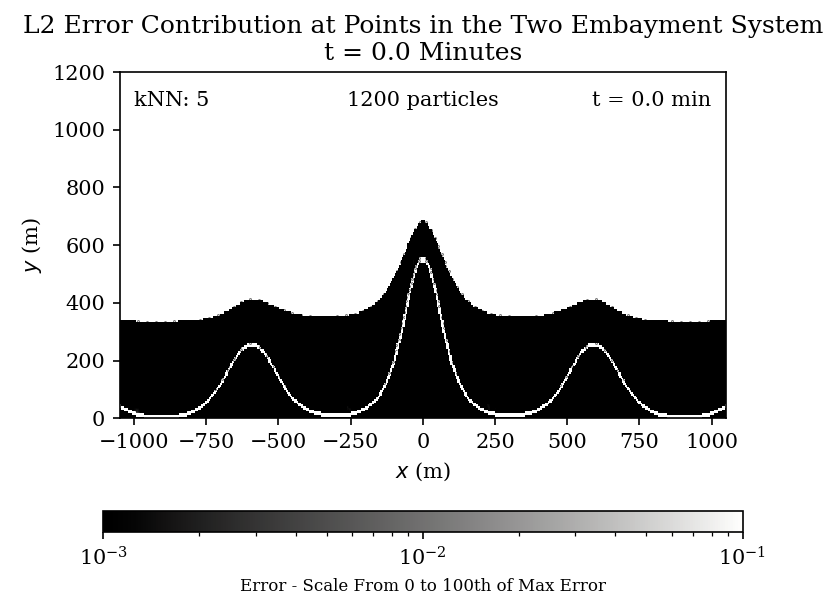

In [276]:
# plt.rcParams.update({"text.usetex": False})

# dpi scales figure up, keeping the base size the same
fig, ax = plt.subplots(figsize = (5.5,4), dpi = 150 )

# vmin and vmax set lower and upper bounds of colormap - derive so centered at 0 based on max value of first array
vmin, vmax = 0, np.nanmax(errorMesh)
vplt = ax.pcolormesh(X, Y, errorMesh, cmap = cmocean.cm.gray, norm = colors.LogNorm(vmin = 1e-3, vmax = 1e-1))  # old cmap ReBu_r?
#vplt = ax.pcolormesh(X, Y, errorMesh, cmap = cmocean.cm.gray, vmin = vmin, vmax = vmax)


# alpha is transparency, k is black
levels = np.linspace(vmin, vmax, 25)
ax.contour(X, Y, errorMesh, levels = levels, linewidths = 0.25, alpha = 0.5, colors = "k" )  

# adds a scatterplot of the positions of particles at the timestep we are plotting
ax.scatter(df.loc[tstep].positions[:,0], df.loc[tstep].positions[:,1], s = 0.05, color = "k")

# draws the land
ax.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), cmap = 'gray')

# t
ax.text(1000,1100,'t = {} min'.format(tstep*sps/60),
        horizontalalignment='right',
        verticalalignment='center')

# kNN
ax.text(-1000,1100, 'kNN: {}'.format(kNN),
        horizontalalignment='left',
        verticalalignment='center')

# particle counter
ax.text(0,1100, '{} particles'.format(np.count_nonzero(~np.isnan(df['vorticity'].values[tstep]))),
        horizontalalignment='center',
        verticalalignment='center')

# axis atributes
ax.set_title('L2 Error Contribution at Points in the Two Embayment System\nt = {} Minutes'.format(tstep*sps/60))
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$y$ (m)')

ax.set_ylim(0,1200)
ax.set_xlim(-1050,1050)
ax.set_aspect("equal")

# colorbar - pad is distance below to place it
cbar = fig.colorbar(vplt, orientation = "horizontal", fraction = 0.05, aspect = 30, pad = .20)
cbar.set_label(label='Error - Scale From 0 to 100th of Max Error', size=8) # can add weight = 'bold'
plt.show()

# Error Data Plots

## Data Setup

In [50]:
dsError = pd.read_csv('/Users/jordan/Library/CloudStorage/GoogleDrive-jords314@gmail.com/My Drive/CICOES/data/errorData.csv')

# filter out negative correlation values and the ncont = 600 case
ds_poscorr = dsError[(dsError['corr'] > 0) & (dsError['ncont'] < 600)] 
ds_poscorr

,ncont,rmse,corr
1,2,0.01584,0.165
2,3,0.01510,0.391
3,4,0.01368,0.531
4,5,0.01154,0.699
5,6,0.00963,0.806
6,8,0.00684,0.914
7,10,0.00613,0.931
8,12,0.00614,0.927
9,15,0.00596,0.931
10,16,0.00635,0.920


In [51]:
# extract the columns of interest
ncont = ds_poscorr[['ncont']].to_numpy().T[0]
rmse = ds_poscorr[['rmse']].to_numpy().T[0]
corr = ds_poscorr[['corr']].to_numpy().T[0]

## Plot of ncont vs rmse

Text(0.5, 1.0, 'Error of LGR Compared to ROMS for 1200 Particles\nEvenly Spread on Different Numbers of Contours')

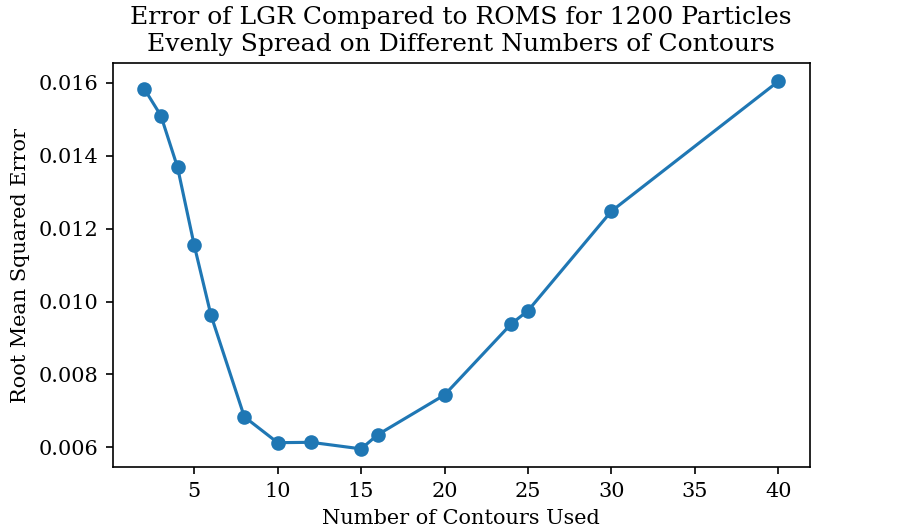

In [71]:
fig, ax = plt.subplots(figsize = (6,3.5), dpi = 150 )

#ax.
ax.scatter(ncont, rmse)
ax.plot(ncont, rmse)


ax.set_xlabel('Number of Contours Used')
ax.set_ylabel('Root Mean Squared Error')
ax.set_title('Error of LGR Compared to ROMS for 1200 Particles\nEvenly Spread on Different Numbers of Contours')

## Time Series Creation

In [52]:
times = []
rmse_t = []
corr_t = []

for i in range(len(df['positions'])) :
    
    # sometimes the last few datapoints are flawed, we want to exit the loop without an error when this happens
    try :
        # .loc selects a timestep, and the scalarfields column. Each element is a dictionary, so we pull out the one we want
        # Each dictionary contains a 2d array array, horizontal values in rows, vertical values in columns, used for plotting
        vorti = np.squeeze(df.loc[i, 'ScalarFields']['vort'])
        vorti[ dsCDF['h_psi'][:,::cff] >= 10 ] = np.nan
    except :
        break
    
    vortveci = vorti.flatten()
    romvortveci = romvortmean_nans.flatten()
    

    errorMeshi = (vorti - romvortmean_nans)**2
    meanl2normi = round( np.sqrt(np.nansum(errorMeshi)/ np.count_nonzero(~np.isnan(errorMeshi))), 5) 
    
    maski = ~np.isnan(romvortveci) & ~np.isnan(vortveci)
    
    corri = round(stats.linregress(romvortveci[maski], vortveci[maski]).rvalue, 3)

    times.append(i*sps/60)
    rmse_t.append(meanl2normi)
    corr_t.append(corri)
    

    
    

Text(0.5, 1.0, 'Error of LGR Compared to ROMS for 1200 Particles\nEvenly Spread on 15 Contours Over Time')

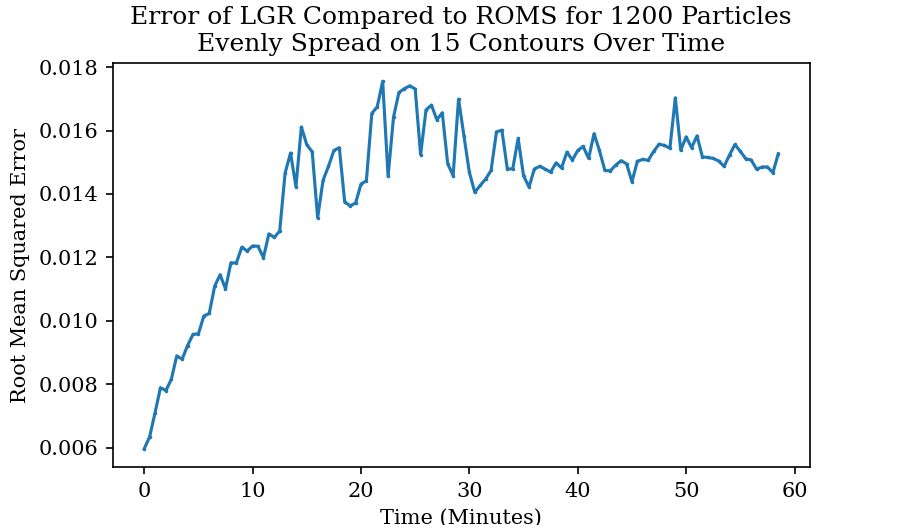

In [53]:
fig, ax = plt.subplots(figsize = (6,3.5), dpi = 150 )

#ax.
ax.plot(times, rmse_t)
ax.scatter(times, rmse_t, s = 0.5)


ax.set_xlabel('Time (Minutes)')
ax.set_ylabel('Root Mean Squared Error')
ax.set_title('Error of LGR Compared to ROMS for 1200 Particles\nEvenly Spread on 15 Contours Over Time')

## POSTER - Joint Error Plots

In [55]:
# transform ncont to the spacing between contours
cont_space = 9/ncont

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharey = True, figsize = (14,13.75), dpi = 1200)

ax1.scatter(cont_space, rmse, c = 'k', s = 200)
ax1.plot(cont_space, rmse, c = 'k', linewidth = 5)

# remove the top and right parts of the frame
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.set_xlabel('Isobath Spacing (m)', size = 24)
ax1.set_ylabel('Error', size = 24)
# ax1.set_title('Error for Various Distances Between Seeded Depth Contours', size = 24)

# set minor tickmarks
ax1.set_xticks(np.linspace(0,5,26), minor=True)
# ax1.set_yticks(np.linspace(0.006,0.018,14), minor=True)

# set the size of the major tick labels
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)



ax2.scatter(times, rmse_t, c = 'k', s = 60)
ax2.plot(times, rmse_t, c = 'k', linewidth = 4)

# remove the top and right parts of the frame
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.set_xlabel('Time (min)', size = 24)
ax2.set_ylabel('Error', size = 24)
# ax2.set_title('Error Over Time', size = 24)

# set minor tickmarks
#ax2.set_xticks(np.linspace(0,60,17), minor=True)
#ax2.set_yticks(np.linspace(0.006,0.018,14), minor=True)

ax2.set_xticks(np.arange(0,60,2), minor=True)
ax2.set_yticks(np.arange(0.007,0.019,0.002), minor=True)

# set the size of the major tick labels
ax2.xaxis.set_tick_params(labelsize=24)
ax2.yaxis.set_tick_params(labelsize=24)


# remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0.3)

# full figure title
# fig.suptitle("Error Comparison of LGR with ROMS", size = 36)

plt.savefig('plots/poster_video/errorPlots.pdf')
plt.close(fig)

## Animation

### POSTER - 1 Hour gif

In [114]:
# vmin and vmax set lower and upper bounds of colormap 
# derive so based on time=0 so that the colorbar doesn't change during animation
vmin, vmax = -max(df['vorticity'].values[0]), max(df['vorticity'].values[0])

# define the color norm for all plots
norm = colors.SymLogNorm(linthresh = 0.01, base = 2, vmin = vmin, vmax = vmax)

# levels for the contour plots
levels = np.linspace(vmin, vmax, 25)

x_rho = dsCDF.x_rho[0,:].values 
y_rho = dsCDF.y_rho[:,0].values
Xrho, Yrho = np.meshgrid(x_rho, y_rho)

# vort = np.squeeze(df.loc[0, 'ScalarFields']['vort'])

for i in range(len(df['positions'])) :

    # .loc selects a timestep, and the scalarfields column. Each element is a dictionary, so we pull out the one we want
    # Each dictionary contains a 2d array array, horizontal values in rows, vertical values in columns, used for plotting

    fig, ax = plt.subplots(figsize = (7,5), dpi = 300) 

    vplt = ax.pcolormesh(X, Y, vort_nofilter, cmap = cmocean.cm.balance, norm = norm)  # old cmap ReBu_r?

    # draws the land
    ax.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), 
                  cmap = colors.ListedColormap(['#FAF6EB', '#ffffff00']), zorder = 10)
    
    # vorticity contour plot - alpha is transparency, k is black
    ax.contour(X, Y, vort_nofilter, levels = levels, linewidths = 0.25, alpha = 0.5, colors = "k")

    # boundary contour
    #ax.contour(Xrho, Yrho, dsCDF['h'], levels = [10], colors = 'red', linestyles = 'dashed')

    # adds a scatterplot of the positions of particles at the timestep we are plotting
    ax.scatter(df.loc[i].positions[:,0], df.loc[i].positions[:,1], s = 0.15, color = "k", zorder = 15)  # s = 0.25
    
    # t
    ax.text(1000,900,'t = {} min'.format(i*sps/60),
            horizontalalignment='right',
            verticalalignment='center')
    
    # # kNN
    # ax.text(-1000,1100, 'kNN: {}'.format(kNN),
    #         horizontalalignment='left',
    #         verticalalignment='center')

    # L2 normed
    # ax.text(0,900, 'L2: {}'.format(meanl2normi),
    #     horizontalalignment='center',
    #     verticalalignment='center')
    
    # particle counter
    ax.text(-1000,900, '{} particles'.format(np.count_nonzero(~np.isnan(df['vorticity'].values[i]))),
            horizontalalignment='left',
            verticalalignment='center')

    ax.set_ylim(0,1000)
    ax.set_xlim(-1050,1050)
    ax.set_aspect("equal")
    
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$y$ (m)')
    ax.set_title('Vorticity and Particle Positions', size = 15)

    # colorbar - pad is distance below to place it
    cbar = fig.colorbar(vplt, orientation = "horizontal", fraction = 0.05, aspect = 30, pad = .20)
    cbar.set_label(label='Vorticity', size=15) # can add weight = 'bold'
    
    # this pads the strings with zeros so that everything is placed in order for easy gif making
    plt.savefig('plots/poster_video/animation/poster/image-'+str(i).zfill(4)+'.png')
    plt.close(fig)

### Particles Only gif

In [589]:
# code to create particle only gif

for i in range(len(df['positions'])) :

    fig, ax = plt.subplots(figsize = (5.5,4), dpi = 150) 

    # draws the land
    ax.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), cmap = 'gray')

    # adds a scatterplot of the positions of particles at the timestep we are plotting
    ax.scatter(df.loc[i].positions[:,0], df.loc[i].positions[:,1], s = 0.25, color = "blue")

    # t
    ax.text(1000,900,'t = {} min'.format(i*sps/60),
            horizontalalignment='right',
            verticalalignment='center')
    
    # particle counter
    ax.text(-1000,900, '{} particles'.format(np.count_nonzero(~np.isnan(df['vorticity'].values[i]))),
            horizontalalignment='left',
            verticalalignment='center')
    
    ax.set_ylim(0,1000)
    ax.set_xlim(-1050,1050)
    ax.set_aspect("equal")
    
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$y$ (m)')
    ax.set_title('Particle Positions After {} Minutes'.format(i*sps/60))
    
    # this pads the strings with zeros so that everything is placed in order for easy gif making
    plt.savefig('plots/poster/3H_1000_particles/image-'+str(i).zfill(4)+'.png')
    plt.close(fig)

### Particles and Vorticity gif

In [595]:
# vmin and vmax set lower and upper bounds of colormap 
# derive so based on time=0 so that the colorbar doesn't change during animation
vmin, vmax = -max(df['vorticity'].values[0]), max(df['vorticity'].values[0])

# define the color norm for all plots
norm = colors.SymLogNorm(linthresh = 0.01, base = 2, vmin = vmin, vmax = vmax)

# levels for the contour plots
levels = np.linspace(vmin, vmax, 25)

x_rho = dsCDF.x_rho[0,:].values 
y_rho = dsCDF.y_rho[:,0].values
Xrho, Yrho = np.meshgrid(x_rho, y_rho)


for i in range(len(df['positions'])) :

    # .loc selects a timestep, and the scalarfields column. Each element is a dictionary, so we pull out the one we want
    # Each dictionary contains a 2d array array, horizontal values in rows, vertical values in columns, used for plotting
    vort = np.squeeze(df.loc[i, 'ScalarFields']['vort'])

    errorMeshi = (vort - romvortmean_nans)**2
    meanl2normi = round( np.sqrt(np.nansum(errorMeshi)/ np.count_nonzero(~np.isnan(errorMeshi))), 5) 

    fig, ax = plt.subplots(figsize = (5.5,4), dpi = 150) 

    vplt = ax.pcolormesh(X, Y, vort, cmap = cmocean.cm.balance, norm = norm)  # old cmap ReBu_r?

    # vorticity contour plot - alpha is transparency, k is black
    ax.contour(X, Y, vort, levels = levels, linewidths = 0.25, alpha = 0.5, colors = "k" )

    # boundary contour
    #ax.contour(Xrho, Yrho, dsCDF['h'], levels = [10], colors = 'red', linestyles = 'dashed')

    # draws the land
    ax.pcolormesh(dsCDF.x_psi, dsCDF.y_psi, np.ma.masked_where(dsCDF.mask_psi == 1, dsCDF.mask_psi), cmap = 'gray')

    # adds a scatterplot of the positions of particles at the timestep we are plotting
    ax.scatter(df.loc[i].positions[:,0], df.loc[i].positions[:,1], s = 0.15, color = "k")  # s = 0.25
    
    # t
    ax.text(1000,900,'t = {} min'.format(i*sps/60),
            horizontalalignment='right',
            verticalalignment='center')
    
    # # kNN
    # ax.text(-1000,1100, 'kNN: {}'.format(kNN),
    #         horizontalalignment='left',
    #         verticalalignment='center')

    # L2 normed
    ax.text(0,900, 'L2: {}'.format(meanl2normi),
        horizontalalignment='center',
        verticalalignment='center')
    
    # particle counter
    ax.text(-1000,900, '{} particles'.format(np.count_nonzero(~np.isnan(df['vorticity'].values[i]))),
            horizontalalignment='left',
            verticalalignment='center')

    ax.set_ylim(0,1000)
    ax.set_xlim(-1050,1050)
    ax.set_aspect("equal")
    
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$y$ (m)')
    ax.set_title('Vorticity and Particle Positions')

    # colorbar - pad is distance below to place it
    cbar = fig.colorbar(vplt, orientation = "horizontal", fraction = 0.05, aspect = 30, pad = .20)
    cbar.set_label(label='Vorticity', size=8) # can add weight = 'bold'
    
    # this pads the strings with zeros so that everything is placed in order for easy gif making
    plt.savefig('plots/poster/3H_1000_vort/image-'+str(i).zfill(4)+'.png')
    plt.close(fig)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x177464280> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [596]:
plt.close('all')

## Gif Command Line Code (ffmpeg)

In [ ]:
plt.close('all')

# Extra